<a href="https://colab.research.google.com/github/bt22dr/PRML/blob/master/PRML_chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Probability Distributions

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install scipy
!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 2.1 Binary Variables
#### The Bernoulli Distribution

In [0]:
class Bernoulli:
  def __init__(self, mu=None):
    if mu:
      assert self.check_parameter(mu), "0 <= mu <= 1"
    self.mu = mu

  def check_support(self, x):
    if np.isscalar(x):
      return x in [0, 1]
    else:
      return all([e in [0, 1] for e in x])

  def check_parameter(self, mu):
    return 0 <= mu <= 1
  
  def mean(self):
    return self.mu # (식 2.3)
  
  def variance(self):
    mu = self.mu
    return mu * (1. - mu) # (식 2.4)

  def pmf(self, x):
    assert self.check_support(x), "x in {0, 1}"
    mu = self.mu
    x = tf.cast(x, tf.float32)
    return tf.math.pow(mu, x) * tf.math.pow((1. - mu), (1 - x)) # (식 2.2)

  def likelihood(self, D, mu):
    D = tf.cast(D, tf.float32)
    pow = tf.math.pow
    subtract = tf.math.subtract
    return tf.reduce_prod(
        [(pow(mu, x_n) * pow(subtract(1., mu), (1. - x_n))) for x_n in D], 
        axis=0) # (식 2.5)

  def log_likelihood(self, D, mu):
    D = tf.cast(D, tf.float32)
    return tf.reduce_sum(
        D * tf.math.log(mu) + (1. - D) * tf.math.log(1. - mu)) # (식 2.6)
    
  def mle(self, D):
    self.mu = np.mean(D) # (식 2.7)
    return self.mu

In [3]:
my_bern = Bernoulli(0.1)
print(my_bern.pmf(0), my_bern.pmf(1))
print(tf.math.log(my_bern.pmf([0, 1])))

tf.Tensor(0.9, shape=(), dtype=float32) tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor([-0.10536055 -2.3025851 ], shape=(2,), dtype=float32)


In [4]:
tf_bern = tfp.distributions.Bernoulli(probs=0.1)
print(tf_bern.prob(0), tf_bern.prob(1))
print(tf_bern.log_prob([0, 1]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
tf.Tensor(0.90000004, shape=(), dtype=float32) tf.Tensor(0.099999994, shape=(), dtype=float32)
tf.Tensor([-0.10536051 -2.3025851 ], shape=(2,), dtype=float32)


In [5]:
D = tf.reshape(tf.constant([1,1,1]), shape=(-1, 1))
print(my_bern.mle(D))

1.0


In [6]:
D = tf.reshape(tf.constant([1]), shape=(-1, 1))
print(my_bern.likelihood(D, 0.0), my_bern.likelihood(D, 1.0))

tf.Tensor([0.], shape=(1,), dtype=float32) tf.Tensor([1.], shape=(1,), dtype=float32)


#### The Binomial Distribution

In [0]:
def binomial_coefficient(N, m):
  from scipy.special import factorial
  return factorial(N) / (factorial(tf.math.subtract(N, m)) * factorial(m))
  
class Binomial:
  def __init__(self, N, mu):
    assert self.check_parameter(N, mu), "N >= 0 and 0 <= mu <= 1"
    self.N = N
    self.mu = mu

  def check_support(self, m):
    if np.isscalar(m):
      return m in range(self.N+1)
    else:
      return all([e in range(self.N+1) for e in m])

  def check_parameter(self, N, mu):
    return N >= 0 and 0 <= mu <= 1
  
  def mean(self):
    return N * self.mu
  
  def variance(self):
    mu = self.mu
    return N * mu * (1. - mu)

  def pmf(self, m):
    assert self.check_support(m), "m in {0,1,... ,N}"
    N, mu = self.N, self.mu
    m = tf.cast(m, tf.float32)
    pow = tf.math.pow
    # (식 2.9)
    return binomial_coefficient(N, m) * pow(mu, m) * pow((1 - mu), (N - m))

In [8]:
my_bin = Binomial(10, 0.25)
print(my_bin.pmf(2))
print(my_bin.pmf([2,3]))

tf.Tensor(0.28156757, shape=(), dtype=float32)
tf.Tensor([0.28156757 0.2502823 ], shape=(2,), dtype=float32)


<BarContainer object of 11 artists>

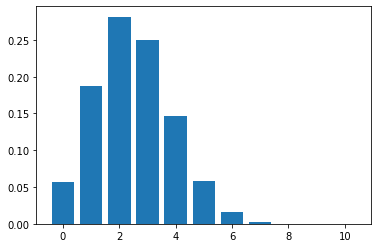

In [9]:
x = range(11)
plt.bar(x, my_bin.pmf(x))

### 2.1.1 The Beta Distribution

In [0]:
def beta_coefficient(a, b):
  return math.gamma(a+b) / (math.gamma(a) * math.gamma(b))

class Beta:
  def __init__(self, a, b):
    assert self.check_parameter(a, b), "a > 0 and b > 0"
    self.a, self.b = a, b

  def check_support(self, mu):
    if np.isscalar(mu):
      return 0 <= mu <= 1
    else:
      return all([0 <= e <= 1 for e in mu])

  def check_parameter(self, a, b):
    return a > 0 and b > 0
  
  def mean(self):
    a, b = self.a, self.b
    return a / (a + b) # (식 2.15)
  
  def variance(self):
    a, b = self.a, self.b
    (a * b) / ((a + b)**2 * (a + b + 1)) # (식 2.16)

  def pdf(self, mu):
    assert self.check_support(mu), "0 <= mu <= 1"
    a, b = tf.cast(self.a, tf.float32), tf.cast(self.b, tf.float32)
    pow = tf.math.pow
    subtract = tf.math.subtract
    # (식 2.13)
    return beta_coefficient(a,b) * pow(mu, (a-1)) * pow(subtract(1., mu), (b-1))

In [11]:
my_beta = Beta(0.1,0.1)
print(my_beta.pdf(0.5))
print(my_beta.pdf([0, 0.5, 1.]))

tf.Tensor(0.17663027, shape=(), dtype=float32)
tf.Tensor([       inf 0.17663027        inf], shape=(3,), dtype=float32)


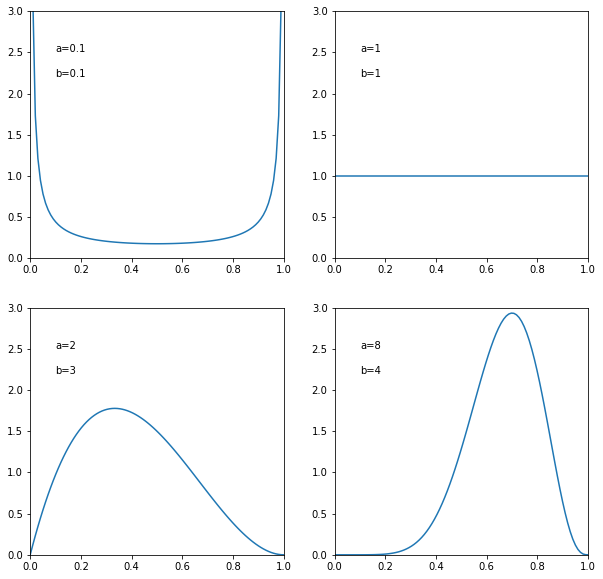

In [12]:
plt.figure(figsize=(10,10))
x = np.linspace(0, 1, 100)
for i, [a, b] in enumerate([[0.1, 0.1], [1, 1], [2, 3], [8, 4]]):
    plt.subplot(2, 2, i + 1)
    my_beta = Beta(a, b)
    plt.xlim(0, 1)
    plt.ylim(0, 3)
    plt.plot(x, my_beta.pdf(x))
    plt.annotate("a={}".format(a), (0.1, 2.5))
    plt.annotate("b={}".format(b), (0.1, 2.2))
plt.show()

In [0]:
a, b = 2, 2
m, l = 1, 0

c_prior = beta_coefficient(a, b)
c_likelihood = binomial_coefficient(m+l, m)
c_posterior = beta_coefficient(m+a, l+b)
C = c_posterior / c_prior / c_likelihood

prior = Beta(a, b)
likelihood = Bernoulli()

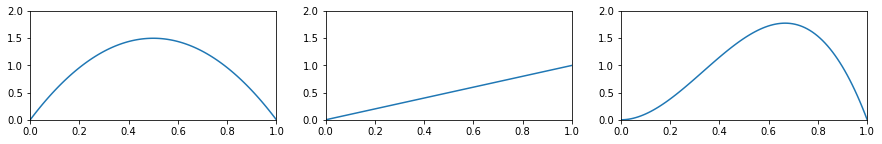

In [14]:
x = np.linspace(0, 1, 100)
y_prior = prior.pdf(x)
y_likelihood = likelihood.likelihood([1], x)
y_posterior = C * y_likelihood * y_prior # (식 2.18)과 동일한 결과가 나와야함
ys = [y_prior, y_likelihood, y_posterior]

plt.figure(figsize=(15, 2))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.xlim(0, 1)
  plt.ylim(0, 2)
  plt.plot(x, ys[i])

## 2.2 Multinomial Variables
#### The Multinoulli Distribution

In [0]:
class Multinoulli:
  def __init__(self, mu=None):
    if mu is not None:
      assert self.check_parameter(mu), "mu >= 0 & sum(mu) == 1"
    self.mu = mu

  def check_support(self, x):
    if np.isscalar(x):
      return x in range(1, len(self.mu)+1)
    else:
      return all([e.numpy() in [0, 1] for e in x]) and np.sum(x) == 1

  def check_parameter(self, mu):
    return all([e >= 0 for e in mu]) and np.sum(mu) == 1 # (식 2.27)
  
  def mean(self):
    return self.mu # (식 2.28)
  
  def pmf(self, x):
    assert self.check_support(x), "x in {1, ..., len(mu)} or one_hot(x)"
    mu = self.mu
    if np.isscalar(x):
      x = tf.reshape(tf.one_hot(x-1, len(mu)), [-1, 1]) # (식 2.25)
    x = tf.cast(x, tf.float32)
    return tf.reduce_prod(tf.math.pow(mu, x))

  def likelihood(self, D, mu):
    D = tf.cast(D, tf.float32)
    m_k = tf.reshape(tf.reduce_sum(D, axis=0), [-1, 1])
    return tf.reduce_prod(tf.math.pow(mu, m_k)) # (식 2.29)

  def mle(self, D):
    D = tf.cast(D, tf.float32)
    m_k = tf.reshape(tf.reduce_sum(D, axis=0), [-1, 1])
    self.mu = tf.reduce_mean(D, axis=0) # (식 2.33)
    return self.mu

In [16]:
mu = tf.reshape(tf.constant([0.1, 0.4, 0.5]), [3, 1])
x  = tf.reshape(tf.constant([1, 0, 0]), [3, 1])
D  = np.array([[0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 0, 1]])

my_cate = Multinoulli(mu)
print(my_cate.mean())
print(my_cate.pmf(x))
print(my_cate.pmf(3))
print(my_cate.likelihood(D, mu))
print(my_cate.mle(D))

tf.Tensor(
[[0.1]
 [0.4]
 [0.5]], shape=(3, 1), dtype=float32)
tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(0.002, shape=(), dtype=float32)
tf.Tensor([0.5  0.25 0.25], shape=(3,), dtype=float32)


#### The Multinomial Distribution

In [0]:
def multinomial_coefficient(N, m):
  from scipy.special import factorial
  return factorial(N) / tf.reduce_prod(factorial(m))
  
class Multinomial:
  def __init__(self, N, mu):
    assert self.check_parameter(N, mu), "N > 0 and 0 <= mu <= 1"
    self.N = N
    self.mu = mu

  def check_support(self, m):
    if np.isscalar(x):
      return x in range(1, len(self.mu)+1)
    else:
      return all([e.numpy() in [0, 1] for e in x]) and np.sum(x) == 1

  def check_parameter(self, N, mu):
    return N > 0 and all([e >= 0 for e in mu]) and np.sum(mu) == 1
  
  def pmf(self, m):
    #assert self.check_support(m), "m in {0,1,... ,N}"
    N, mu = self.N, self.mu
    m = tf.cast(m, tf.float32)
    return multinomial_coefficient(N, m) * tf.reduce_prod(tf.math.pow(mu, m))

In [18]:
mu = tf.constant([.2, .3, .5], shape=[3, 1])
x  = tf.constant([1, 0, 3], shape=[3, 1])
my_mult = Multinomial(4, mu)
my_mult.pmf(x)

<tf.Tensor: id=624, shape=(), dtype=float32, numpy=0.1>

In [19]:
p = [.2, .3, .5]
dist = tfd.Multinomial(total_count=4., probs=p)
counts = [1, 0, 3]
dist.prob(counts)

<tf.Tensor: id=649, shape=(), dtype=float32, numpy=0.099999994>

### 2.2.1 The Dirichlet distribution

In [0]:
eps = 1.e-3

def dirichlet_coefficient(alpha):
  return math.gamma(
      tf.reduce_sum(alpha)) / tf.reduce_prod([math.gamma(e) for e in alpha])

class Dirichlet:
  def __init__(self, alpha):
    assert self.check_parameter(alpha), "alpha_k > 0, K >= 2"
    self.alpha = alpha

  def check_support(self, mu):
    return all([e > 0 for e in mu]) and np.abs(np.sum(mu) - 1) < eps

  def check_parameter(self, alpha):
    return all([e > 0 for e in alpha]) and len(alpha) >= 2

  def pdf(self, mu):
    assert self.check_support(mu), "mu > 0 & sum(mu) == 1"
    alpha = tf.cast(self.alpha, tf.float32)
    pow = tf.math.pow
    subtract = tf.math.subtract
    return dirichlet_coefficient(alpha) * tf.reduce_prod(pow(mu, alpha-1))


In [21]:
alpha = tf.constant([1, 2, 3], shape=[3,1])
x = tf.constant([.2, .3, .5], shape=[3,1])
my_dir = Dirichlet(alpha)
my_dir.pdf(x)

<tf.Tensor: id=721, shape=(), dtype=float32, numpy=4.5>

In [22]:
alpha = [1, 2, 3]
dist = tfd.Dirichlet(alpha)

# x has one sample, one batch, three classes:
x = [.2, .3, .5]   # shape: [3]
dist.prob(x)       # shape: []

<tf.Tensor: id=739, shape=(), dtype=float32, numpy=4.5>

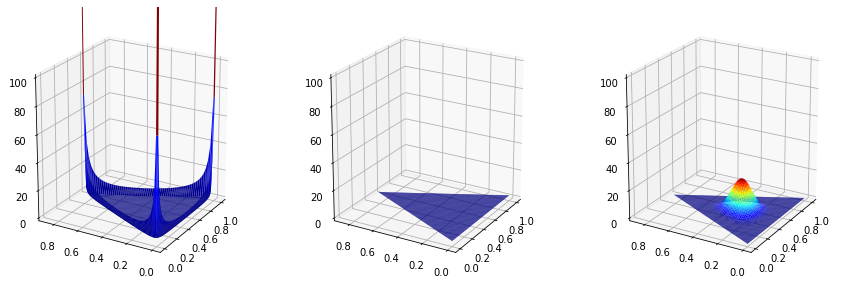

In [23]:
# 참고
# * https://gist.github.com/tboggs/8778945
# * https://datascienceschool.net/view-notebook/5deb23973a0240beb510cc2cd3b2f43d

import matplotlib.tri as tri
from matplotlib import ticker, cm
from mpl_toolkits.mplot3d import Axes3D

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-3):
  s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
        for i in range(3)]
  return np.clip(s, tol, 1.0 - tol)

def draw_pdf_contours(dist, ax, subdiv=6, **kwargs):
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy, tol=eps)) for xy in zip(trimesh.x, trimesh.y)]

    ax.plot_trisurf(trimesh.x, trimesh.y, pvals, cmap=cm.jet, linewidth=0.2)
    ax.view_init(20, 210)
    ax.set_zlim(0, 100) # ax.set_aspect('equal', 'datalim')

fig, axes = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'projection': '3d'})
alphas = [[0.1] * 3,
          [1] * 3,
          [10] * 3]
for (i, alpha) in enumerate(alphas):
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist, axes[i])

## 2.3 The Gaussian Distribution

* univariate gaussian distribution

In [0]:
class Gaussian:
  def __init__(self, mu=None, var=None):
    self.mu = mu
    self.var = var
    if mu is not None:
      assert self.check_parameter_mu(mu), "mu in R"
      self.mu = tf.cast(mu, tf.float32)
    if var is not None:
      assert self.check_parameter_var(var), "var > 0 and var.shape == mu.shape"
      self.var = tf.cast(var, tf.float32)
    
  def check_support(self, x):
    if np.isscalar(x):
      return not isinstance(x, complex)
    else:
      return all([not isinstance(e, complex) for e in x])

  def check_parameter_mu(self, mu):
    if np.isscalar(mu):
      return not isinstance(mu, complex)
    else:
      return all([not isinstance(e, complex) for e in mu])
  
  def check_parameter_var(self, var):
    if np.isscalar(var):
      return var > 0
    else:
      return all([e > 0 for e in var]) and mu.shape == var.shape

  def mean(self):
    return self.mu
  
  def variance(self):
    return self.var

  def pdf(self, x):
    assert self.check_support(x), "x in R"
    mu = self.mu
    var = self.var
    x = tf.cast(x, tf.float32)

    d = tf.math.subtract(x, mu)
    return (tf.math.exp(-0.5 / var * d ** 2) / tf.math.sqrt(2 * np.pi * var))
  
  def mle(self, D):
    pass

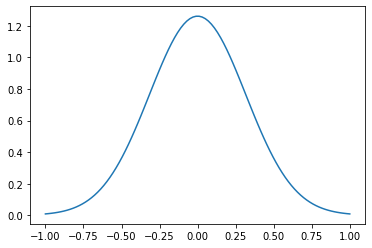

In [25]:
my_norm = Gaussian(0, 0.1)
x = np.linspace(-1, 1, 100)
plt.plot(x, my_norm.pdf(x))

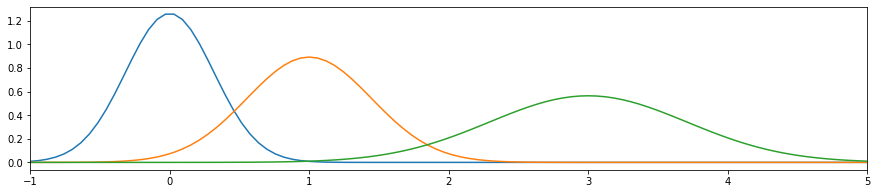

In [26]:
mu = tf.constant([0, 1, 3], shape=[3,1])
var = tf.constant([.1, .2, .5], shape=[3,1])
my_norm = Gaussian(mu, var)

x = np.linspace(-1, 5, 100)
plt.figure(figsize=(15, 3))
plt.xlim(-1, 5)
plt.plot(x, my_norm.pdf(x)[0], x, my_norm.pdf(x)[1], x, my_norm.pdf(x)[2])
plt.show()

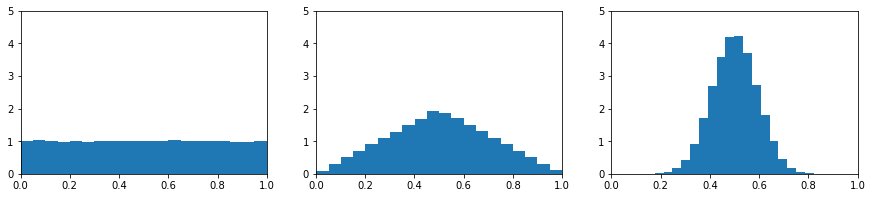

In [27]:
Ns = [1, 2, 10]
tf_unif = tfd.Uniform()
plt.figure(figsize=(15, 3))
for i, N in enumerate(Ns):
  sum_of_rvs = tf.reduce_mean(tf_unif.sample(sample_shape=(N, 100000)), axis=0)
  plt.subplot(1, 3, i+1)
  plt.xlim(0, 1)
  plt.ylim(0, 5)
  plt.hist(sum_of_rvs, bins=20, density=True)

In [0]:
class MultivariateGaussian:
  def __init__(self, mu=None, cov=None):
    self.mu = mu
    self.cov = cov
    if mu is not None and cov is not None:
      self.mu = tf.reshape(tf.cast(mu, tf.float32), shape=[-1, 1])
      self.D  = self.mu.shape[0]
      self.cov = tf.cast(cov, tf.float32)

  def mean(self):
    return tf.squeeze(self.mu)
  
  def covariance(self):
    return self.cov

  def pdf(self, x):
    mu = self.mu
    cov = self.cov
    
    if tf.rank(x) == 1:
      x = tf.expand_dims(x, 0)
    x = tf.transpose(tf.cast(x, tf.float32))
    d = tf.math.subtract(x, mu)
    precision_mat = tf.linalg.inv(cov)
    return tf.squeeze(
      tf.linalg.diag_part(
        tf.math.exp(-0.5 * tf.matmul(
            tf.matmul(tf.transpose(d), precision_mat), d))
        / tf.math.sqrt(tf.linalg.det(cov))
        / tf.math.pow(2 * np.pi, 0.5 * self.D)))

  def mle(self, D):
    N = len(D)
    sample_mean = tf.reduce_mean(D, axis=0) # (식 2.122)
    self.mu = tf.reshape(sample_mean, shape=[-1, 1])
    D = tf.transpose(D)
    d = tf.subtract(D, self.mu)
    self.cov = (1/(N-1) * tf.matmul(d, tf.transpose(d))) # (식 2.125)

    return self.mean(), self.covariance()

In [29]:
mu = tf.constant([0,0,0])
cov = tf.constant(
    [[ 1,  0,  0],
     [ 0,  1,  0],
     [ 0,  0,  1]])

my_gaus = MultivariateGaussian(mu, cov)

x = tf.constant([0,0,0])
print(my_gaus.pdf(x))

x = tf.constant([[0,0,0], [1,1,1]])
print(my_gaus.pdf(x))

tf.Tensor(0.06349363, shape=(), dtype=float32)
tf.Tensor([0.06349363 0.01416735], shape=(2,), dtype=float32)


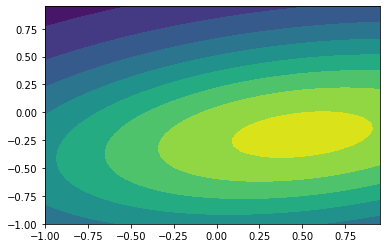

In [30]:
x, y = np.mgrid[-1:1:.05, -1:1:.05]
myrv = MultivariateGaussian([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
data = np.reshape(np.array([x, y]), (2,-1)).T
p = tf.reshape(myrv.pdf(data), x.shape)
plt.contourf(x, y, p)

In [31]:
from scipy.stats import multivariate_normal

rv = multivariate_normal([0,0,0], [[1,0,0], [0,1,0], [0,0,1]])
print(rv.pdf([[0,0,0], [1,1,1]]))

[0.06349364 0.01416735]


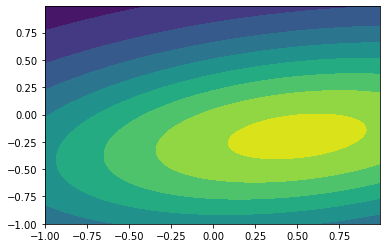

In [32]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
plt.contourf(x, y, rv.pdf(pos))

$$\Sigma \bf{u}_i = \lambda_i \bf{u}_i$$
$$\bf{y} = \bf{U} ( \bf{x} - \boldsymbol{\mu})$$

x 좌표계에서 (4,2)의 y 좌표계에서의 좌표: [0. 0.]
x 좌표계에서 (0,0)의 y 좌표계에서의 좌표: [-0.56322885 -4.4365273 ]


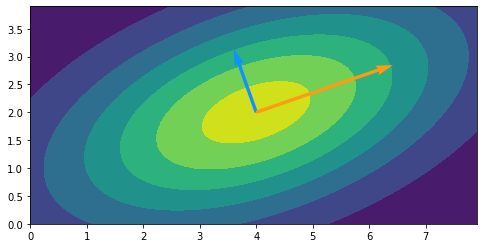

In [33]:
mu = tf.constant([4., 2.])
cov = tf.constant([[3.0, 0.8], [0.8, 1.0]])*2
myrv = MultivariateGaussian(mu, cov)

lamb = tf.linalg.eigh(cov)[0]
U = tf.linalg.eigh(cov)[1]

y_coord = tf.linalg.matvec(U, tf.subtract([4,2],mu))
print("x 좌표계에서 (4,2)의 y 좌표계에서의 좌표:", y_coord.numpy())
y_coord = tf.linalg.matvec(U, tf.subtract([0,0],mu))
print("x 좌표계에서 (0,0)의 y 좌표계에서의 좌표:", y_coord.numpy())

x, y = np.mgrid[0:8:.1, 0:4:.1]
data = np.reshape(np.array([x, y]), (2,-1)).T
p = tf.reshape(myrv.pdf(data), x.shape)
plt.figure(figsize=(8,4))
plt.contourf(x, y, p)

def plot_axes(vecs, mu, cols=["#1190FF", "#FF9A13"]):
  for i in range(len(vecs)):
    x = np.concatenate([mu,vecs[i]])
    plt.quiver(*x,angles='xy', scale_units='xy', scale=1, color=cols[i])

y_axis = U*tf.pow(lamb, 1/2)
plot_axes([y_axis[:,0], y_axis[:,1]],mu)

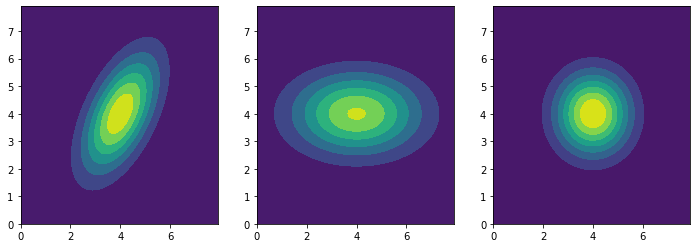

In [34]:
mu = tf.constant([4., 4.])
cov = tf.constant([[[1.0, 0.8], [0.8, 2.0]],  # general form
                   [[3.0, 0.0], [0.0, 1.0]],  # diagonal
                   [[1.0, 0.0], [0.0, 1.0]]]) # proportional to the identity 

x, y = np.mgrid[0:8:.1, 0:8:.1]
data = np.reshape(np.array([x, y]), (2,-1)).T

plt.figure(figsize=(12, 4))
for i in range(3):
  myrv = MultivariateGaussian(mu, cov[i])
  p = tf.reshape(myrv.pdf(data), x.shape)
  plt.subplot(1, 3, i+1)
  plt.contourf(x, y, p)

### 2.3.1 Conditional Gaussian distributions

In [0]:
mu = tf.constant([0.5,0.5])
cov = tf.constant([[1.0, 0.95], [0.95, 1.0]])*0.03
joint_dist = MultivariateGaussian(mu, cov)

In [0]:
# (식 2.94)
mu_a, mu_b = mu

# (식 2.95)
cov_aa,cov_ab = tf.slice(cov, [0,0],[1,1]), tf.slice(cov, [1,0],[1,1])
cov_ba,cov_bb = tf.slice(cov, [0,1],[1,1]), tf.slice(cov, [1,1],[1,1])
prec = tf.linalg.inv(cov)
prec_aa,prec_ab = tf.slice(prec, [0,0],[1,1]), tf.slice(prec, [1,0],[1,1]) 
prec_ba,prec_bb = tf.slice(prec, [0,1],[1,1]), tf.slice(prec, [1,1],[1,1])

# (식 2.97)
def conditional_mu(x_b):
  return mu_a - tf.linalg.matvec(
      tf.matmul(tf.linalg.inv(prec_aa), prec_ab),
      tf.subtract(x_b, mu_b))

In [37]:
x_b = [0.7]
mu_a_given_b = conditional_mu(x_b)

# (식 2.96)
conditional_dist = MultivariateGaussian(mu_a_given_b, tf.linalg.inv(prec_aa))
print("CONDITIONAL DISTRIBUTION:\n", 
      conditional_dist.mean(), conditional_dist.covariance())

CONDITIONAL DISTRIBUTION:
 tf.Tensor(0.69, shape=(), dtype=float32) tf.Tensor([[0.002925]], shape=(1, 1), dtype=float32)


### 2.3.2 Marginal Gaussian distributions

In [38]:
# (식 2.98)
marginal_dist = MultivariateGaussian(mu_a, cov_aa)
print("MARGINAL DISTRIBUTION:\n", 
      marginal_dist.mean(), marginal_dist.covariance())

MARGINAL DISTRIBUTION:
 tf.Tensor(0.5, shape=(), dtype=float32) tf.Tensor([[0.03]], shape=(1, 1), dtype=float32)


(0, 10)

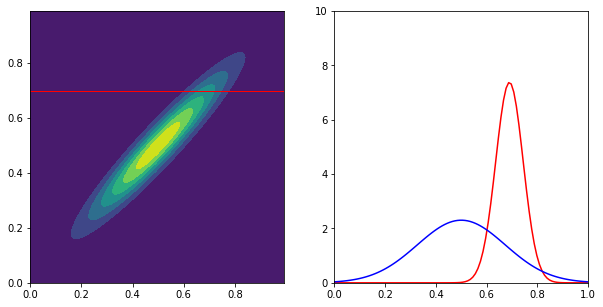

In [39]:
x, y = np.mgrid[0:1:.01, 0:1:.01]
myrv = MultivariateGaussian(mu, cov)
data = np.reshape(np.array([x, y]), (2,-1)).T
p = tf.reshape(myrv.pdf(data), x.shape)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.contourf(x, y, p)
plt.axhline(y=x_b, color='r', linewidth=1)

plt.subplot(1, 2, 2)
mu = tf.squeeze(conditional_dist.mean()).numpy()
var = tf.squeeze(conditional_dist.covariance()).numpy()
dist = Gaussian(mu, var)
x = np.linspace(0, 1, 100)
plt.plot(x, dist.pdf(x), 'r')

mu = tf.squeeze(marginal_dist.mean()).numpy()
var = tf.squeeze(marginal_dist.covariance()).numpy()
dist = Gaussian(mu, var)
x = np.linspace(0, 1, 100)
plt.plot(x, dist.pdf(x), 'b')
plt.xlim(0,1); plt.ylim(0,10)

### 2.3.4 Maximum likelihood form the Gaussian

In [40]:
X = np.random.normal(loc=1., scale=2., size=(10000, 2))
gaussian = MultivariateGaussian()
gaussian.mle(X)
print(gaussian.mean(), gaussian.covariance())

tf.Tensor([1.00436585 1.03590818], shape=(2,), dtype=float64) tf.Tensor(
[[3.86343391 0.05212482]
 [0.05212482 4.01739786]], shape=(2, 2), dtype=float64)


### 2.3.6 Bayesian inference for the Gaussian

In [0]:
# TODO: 
class Gamma:
  def __init__(self, a=None, b=None):
    pass
  def pdf(self, x):
    pass

In [0]:
# TODO:
prior_gamma_dist = Gamma()
likelihood_gauss_dist = Gaussian()
# posterior_gamma_dist = likelihood_gauss_dist.pdf() * prior_gamma_dist.pdf()